In [1]:
#set up

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from fredapi import Fred
from math import sqrt
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### lagged features function

In [2]:
#creates a lagged column for each column

def buildLaggedFeatures(df, tau):
    df_lagged = df.copy()
    
    #creating a duplicate column for each existing column and shifting it by tau, thus creating "lag"
    
    for window in range(0, tau + 1):
        shifted = df.shift(window)
        shifted.columns = [x + "_tau" + str(window) for x in df.columns]

        df_lagged = pd.concat((df_lagged, shifted), axis=1)

    
    return df_lagged

### connecting to FRED API to pull data

In [3]:
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# gathering fred data (currently as series)
data1 = fred.get_series('PCECC96')             # Real personal Consumption expenditures (qtr)

data2 = fred.get_series('UMCSENT')             # University of Michigan: Consumer Sentiment: (month)
    
# data3 = fred.get_series('BOGZ1FA154104023Q') # Households and Nonprofit Organizations; Debt     (qtr)
#                                              # Service Payments (FSIs), Transactions


### reindexing data

In [4]:
d1 = pd.DataFrame({'date':data1.index, 'PCECC96':data1.values})
d2 = pd.DataFrame({'date':data2.index, 'UMCSENT':data2.values})
# d3 = pd.DataFrame({'date':data3.index, 'BOGZ1FA154104023Q':data3.values})

### Merging data

In [5]:
# MERGING!
# d2 is the oldest so we will merge on it (left merge)

df = pd.merge(d1, d2, how="right", on="date")
# df = pd.merge(df, d3, how="left", on="date")

# read in stimulus payment plans
# d4 = pd.read_excel('stimulus_payments.xlsx')
# d4 = d4.rename(columns={'Date':'date'})

# read in federal government transfer payment

data4 = fred.get_series('B087RC1Q027SBEA') # total transactions
data5 = fred.get_series('CPALTT01USQ657N') # CPI
data6 = fred.get_series('UNRATE')          # unemployment
data7 = fred.get_series('INTDSRUSM193N')   # interest rate 
d8 = pd.read_excel('stimulus_payments.xlsx')
data9 = fred.get_series('PSAVERT')   # savings rate 



d4 = pd.DataFrame({'date':data4.index, 'B087RC1Q027SBEA':data4.values}) # total transactions
d5 = pd.DataFrame({'date':data5.index, 'CPALTT01USQ657N':data5.values}) # CPI
d6 = pd.DataFrame({'date':data6.index, 'UNRATE':data6.values})        
d7 = pd.DataFrame({'date':data7.index, 'INTDSRUSM193N':data7.values})          
d8 = d8.rename(columns={'Date':'date'})
d9 = pd.DataFrame({'date':data9.index, 'PSAVERT':data9.values})      

# # merge in stimulus payment plans
df = pd.merge(df, d4, how="left", on="date")
df = pd.merge(df, d5, how="left", on="date")
df = pd.merge(df, d6, how="left", on="date")
df = pd.merge(df, d7, how="left", on="date")
df = pd.merge(df, d9, how="left", on="date")
# df = df.dropna() # interpolate on the non nan

### cubic spline interpolation - not used, just tested

In [6]:
# # # drop everything before 2020-01 and after 2022-04
# df = df[df['date'] >= '2020-01']
# df = df[df['date'] <= '2022-01']

# # # convert to a unique number
# date = df['date']

# df['date'] = (df['date'] - pd.Timestamp("1900-01-01")) // pd.Timedelta('1s')

# # fill gaps in a column in my DataFrame using a cubic spline
# df2 = df.dropna() # interpolate on the non nan

# f = interp1d(df2['date'], df2['Debt Service Payments'], kind='cubic')

# df['Debt Service Payments'] = df['date'].apply(f)

# # Source: https://stackoverflow.com/questions/13930367/interpolating-time-series-in-pandas-using-cubic-spline

### Renaming columns and dropping/filling in Null Values

In [7]:
df = df.rename(columns={'PCECC96':'Consumption'})
df = df.rename(columns={'B087RC1Q027SBEA':'Govt_Transfers'})
df = df.rename(columns={'UMCSENT':'Consumer Sentiment'})
df = df.rename(columns={'CPALTT01USQ657N':'CPI'})
df = df.rename(columns={'UNRATE':'Unemployment_Rate'})
df = df.rename(columns={'UMCSENT':'Consumer_Sentiment'})
df = df.rename(columns={'INTDSRUSM193N':'Interest_Rate'})
df = df.rename(columns={'PSAVERT':'Savings_Rate'})

# merging in stimulus data
df1 = pd.merge(df, d8, how="left", on="date")
df1 = df1.rename(columns={'Stimulus Payement Total (Billions)':'Stimi'})


In [8]:
# df['date'] = df.date.dt.to_period("M")
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                840 non-null    datetime64[ns]
 1   Consumption         279 non-null    float64       
 2   Consumer Sentiment  630 non-null    float64       
 3   Govt_Transfers      279 non-null    float64       
 4   CPI                 251 non-null    float64       
 5   Unemployment_Rate   840 non-null    float64       
 6   Interest_Rate       826 non-null    float64       
 7   Savings_Rate        765 non-null    float64       
 8   Stimi               29 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 65.6 KB


In [9]:
df.dropna(inplace=True)

df1['Stimi'] = df1['Stimi'].fillna(0)
df1.dropna(inplace=True)

In [10]:
# df = df[df['date'] >= '2016-01-01']
# df

### Building lagged features

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 302 to 824
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                175 non-null    datetime64[ns]
 1   Consumption         175 non-null    float64       
 2   Consumer Sentiment  175 non-null    float64       
 3   Govt_Transfers      175 non-null    float64       
 4   CPI                 175 non-null    float64       
 5   Unemployment_Rate   175 non-null    float64       
 6   Interest_Rate       175 non-null    float64       
 7   Savings_Rate        175 non-null    float64       
 8   Stimi               175 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 13.7 KB


In [12]:
df = buildLaggedFeatures(df, 3)
df1 = buildLaggedFeatures(df1, 3)

df = df[['date', 'Consumption','Savings_Rate' ,'Consumer Sentiment','CPI','Unemployment_Rate', 'Interest_Rate',
         'Govt_Transfers',
         'Govt_Transfers_tau1',
         'Govt_Transfers_tau2',
         'Govt_Transfers_tau3']]

df1 = df1[['date', 'Consumption','Savings_Rate' , 'Consumer Sentiment','CPI','Unemployment_Rate', 'Interest_Rate', 'Stimi',
         'Stimi_tau1',
         'Stimi_tau2',
         'Stimi_tau3']]

### OPTIONAL: Droppping entries before certain date

In [13]:
df = df[df['date'] >= '2016-01-01']
df.fillna(0)
df.reset_index()


df1 = df1[df1['date'] >= '2016-01-01']
df1.fillna(0)
df1.reset_index()

,index,date,Consumption,Savings_Rate,Consumer Sentiment,CPI,Unemployment_Rate,Interest_Rate,Stimi,Stimi_tau1,Stimi_tau2,Stimi_tau3
0,758,2016-01-01,12091.178,7.7,92.0,0.064634,4.8,1.00,0.0,0.0,0.0,0.0
1,761,2016-04-01,12152.627,7.2,89.0,1.172351,5.1,1.00,0.0,0.0,0.0,0.0
2,764,2016-07-01,12223.822,6.8,90.0,0.332682,4.8,1.00,0.0,0.0,0.0,0.0
3,767,2016-10-01,12283.076,6.9,87.2,0.222574,4.9,1.00,0.0,0.0,0.0,0.0
4,770,2017-01-01,12369.907,6.9,98.5,0.790737,4.7,1.25,0.0,0.0,0.0,0.0
5,773,2017-04-01,12419.407,7.3,97.0,0.543518,4.4,1.50,0.0,0.0,0.0,0.0
6,776,2017-07-01,12493.466,7.6,93.4,0.396616,4.3,1.75,0.0,0.0,0.0,0.0
7,779,2017-10-01,12630.132,7.4,100.7,0.370630,4.2,1.75,0.0,0.0,0.0,0.0
8,782,2018-01-01,12713.156,7.1,95.7,0.886118,4.0,2.00,0.0,0.0,0.0,0.0
9,785,2018-04-01,12805.609,7.2,98.8,1.033076,4.0,2.25,0.0,0.0,0.0,0.0


In [14]:
df1.describe()

,Consumption,Savings_Rate,Consumer Sentiment,CPI,Unemployment_Rate,Interest_Rate,Stimi,Stimi_tau1,Stimi_tau2,Stimi_tau3
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,12792.157174,10.500000,91.108696,0.624271,5.252174,1.510870,40.478261,36.413043,18.604348,18.604348
std,519.057997,6.274479,8.619107,0.618388,2.538946,0.995667,104.251348,103.912255,64.777104,64.777104
min,11817.147000,6.800000,71.800000,-0.540035,3.500000,0.250000,0.000000,0.000000,0.000000,0.000000
25%,12394.657000,7.250000,87.750000,0.252058,3.900000,0.625000,0.000000,0.000000,0.000000,0.000000
50%,12887.074000,7.700000,93.400000,0.396616,4.400000,1.500000,0.000000,0.000000,0.000000,0.000000
75%,13042.734000,9.600000,98.150000,1.053095,5.250000,2.250000,0.000000,0.000000,0.000000,0.000000
max,13874.396000,33.800000,100.700000,2.339789,14.700000,3.000000,409.600000,409.600000,280.000000,280.000000


### running OLS regression

In [15]:
result_lag_0_a = sm.ols(formula= "Consumption ~ Govt_Transfers        + CPI + Interest_Rate + Unemployment_Rate", data=df).fit()
result_lag_0_s = sm.ols(formula= "Consumption ~ Stimi                 + CPI + Interest_Rate + Unemployment_Rate", data=df1).fit()

result_lag_1_a = sm.ols(formula= "Consumption ~ Govt_Transfers_tau1   + CPI + Interest_Rate + Unemployment_Rate", data=df).fit()
result_lag_1_s = sm.ols(formula= "Consumption ~ Stimi_tau1            + CPI + Interest_Rate + Unemployment_Rate", data=df1).fit()

result_lag_2_a = sm.ols(formula= "Consumption ~ Govt_Transfers_tau2   + CPI + Interest_Rate + Unemployment_Rate", data=df).fit()
result_lag_2_s = sm.ols(formula= "Consumption ~ Stimi_tau2            + CPI + Interest_Rate + Unemployment_Rate", data=df1).fit()

result_lag_3_a = sm.ols(formula= "Consumption ~ Govt_Transfers_tau3   + CPI + Interest_Rate + Unemployment_Rate", data=df).fit()
result_lag_3_s = sm.ols(formula= "Consumption ~ Stimi_tau3            + CPI + Interest_Rate + Unemployment_Rate", data=df1).fit()


In [16]:
multi_test = sm.ols(formula= "Govt_Transfers ~  Unemployment_Rate", data=df).fit()

In [17]:
print(multi_test.summary())

                            OLS Regression Results                            
Dep. Variable:         Govt_Transfers   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     25.26
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           5.64e-05
Time:                        11:07:30   Log-Likelihood:                -178.09
No. Observations:                  23   AIC:                             360.2
Df Residuals:                      21   BIC:                             362.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1300.9430    284.82

In [18]:
print(result_lag_0_a.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     8.280
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           0.000568
Time:                        11:07:30   Log-Likelihood:                -163.92
No. Observations:                  23   AIC:                             337.8
Df Residuals:                      18   BIC:                             343.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.181e+04    438.68

In [19]:
print(result_lag_0_s.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     3.593
Date:                Sun, 27 Nov 2022   Prob (F-statistic):             0.0254
Time:                        11:07:30   Log-Likelihood:                -169.17
No. Observations:                  23   AIC:                             348.3
Df Residuals:                      18   BIC:                             354.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.249e+04    535.69

In [20]:
print(result_lag_1_a.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     9.883
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           0.000206
Time:                        11:07:30   Log-Likelihood:                -162.56
No. Observations:                  23   AIC:                             335.1
Df Residuals:                      18   BIC:                             340.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.164e+04    

In [21]:
print(result_lag_1_s.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     5.184
Date:                Sun, 27 Nov 2022   Prob (F-statistic):            0.00588
Time:                        11:07:30   Log-Likelihood:                -167.11
No. Observations:                  23   AIC:                             344.2
Df Residuals:                      18   BIC:                             349.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.234e+04    474.68

In [22]:
print(result_lag_2_a.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     16.39
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           8.05e-06
Time:                        11:07:30   Log-Likelihood:                -158.27
No. Observations:                  23   AIC:                             326.5
Df Residuals:                      18   BIC:                             332.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.082e+04    

In [23]:
print(result_lag_2_s.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     4.228
Date:                Sun, 27 Nov 2022   Prob (F-statistic):             0.0138
Time:                        11:07:30   Log-Likelihood:                -168.30
No. Observations:                  23   AIC:                             346.6
Df Residuals:                      18   BIC:                             352.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.212e+04    515.45

In [24]:
print(result_lag_3_a.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     7.689
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           0.000851
Time:                        11:07:30   Log-Likelihood:                -164.46
No. Observations:                  23   AIC:                             338.9
Df Residuals:                      18   BIC:                             344.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.122e+04    

In [25]:
print(result_lag_3_s.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     5.069
Date:                Sun, 27 Nov 2022   Prob (F-statistic):            0.00649
Time:                        11:07:30   Log-Likelihood:                -167.24
No. Observations:                  23   AIC:                             344.5
Df Residuals:                      18   BIC:                             350.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.208e+04    490.57

In [26]:
df1.to_excel(r'C:\Users\ianda\Documents\ECON501\finalDataDF1.xlsx', index = False)
df.to_excel(r'C:\Users\ianda\Documents\ECON501\finalDataDF.xlsx', index = False)

array([[<AxesSubplot:title={'center':'Consumer Sentiment'}>]],
      dtype=object)

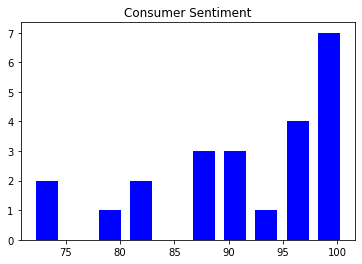

In [27]:
df1.hist(column='Consumer Sentiment',rwidth=.7, grid=0, color='Blue')

# df.hist(column='points', bins=5, grid=False, rwidth=.9, color='purple')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 758 to 824
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 23 non-null     datetime64[ns]
 1   Consumption          23 non-null     float64       
 2   Savings_Rate         23 non-null     float64       
 3   Consumer Sentiment   23 non-null     float64       
 4   CPI                  23 non-null     float64       
 5   Unemployment_Rate    23 non-null     float64       
 6   Interest_Rate        23 non-null     float64       
 7   Govt_Transfers       23 non-null     float64       
 8   Govt_Transfers_tau1  23 non-null     float64       
 9   Govt_Transfers_tau2  23 non-null     float64       
 10  Govt_Transfers_tau3  23 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 2.2 KB


In [29]:
df = df.rename(columns={'Govt_Transfers':'Government Social Benefit Transfer Programs to Person (Billions USD)'})

array([[<AxesSubplot:title={'center':'Government Social Benefit Transfer Programs to Person (Billions USD)'}>]],
      dtype=object)

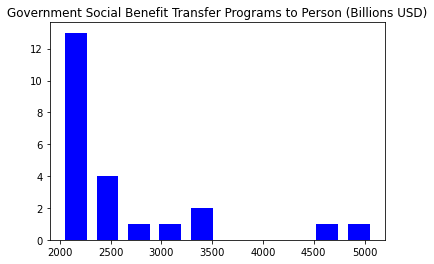

In [30]:
df.hist(column='Government Social Benefit Transfer Programs to Person (Billions USD)',rwidth=.7, grid=0, color='Blue')


array([[<AxesSubplot:title={'center':'Interest_Rate'}>]], dtype=object)

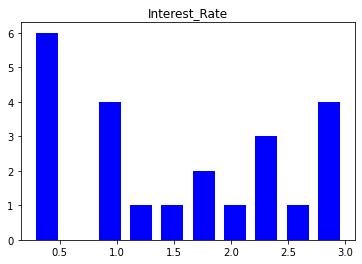

In [31]:
df1.hist(column='Interest_Rate',rwidth=.7, grid=0, color='Blue')


In [34]:
df.describe()


,Consumption,Savings_Rate,Consumer Sentiment,CPI,Unemployment_Rate,Interest_Rate,Government Social Benefit Transfer Programs to Person (Billions USD),Govt_Transfers_tau1,Govt_Transfers_tau2,Govt_Transfers_tau3
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,12792.157174,10.500000,91.108696,0.624271,5.252174,1.510870,2595.118609,2544.832783,2483.183783,2347.172652
std,519.057997,6.274479,8.619107,0.618388,2.538946,0.995667,846.629503,846.750437,833.509197,614.406636
min,11817.147000,6.800000,71.800000,-0.540035,3.500000,0.250000,2006.246000,1989.741000,1977.646000,1966.580000
25%,12394.657000,7.250000,87.750000,0.252058,3.900000,0.625000,2096.440000,2080.692500,2058.747000,2036.304000
50%,12887.074000,7.700000,93.400000,0.396616,4.400000,1.500000,2224.333000,2201.306000,2183.392000,2170.840000
75%,13042.734000,9.600000,98.150000,1.053095,5.250000,2.250000,2644.520500,2376.919500,2340.064000,2326.590000
max,13874.396000,33.800000,100.700000,2.339789,14.700000,3.000000,5094.836000,5094.836000,5094.836000,4698.701000
